
<img src="../pics/DO_Logo.PNG" alt="logo" style="width:150px;"/>


<div align="center">
    <h1><strong>&#x1F333; Reddit Trees - constructing conversation trees from posts.</strong></h1>
</div> 

The purpose of this notebook is to guide researchers through the process of assembling conversation trees from Reddit posts. The notebook accepts dataframes as input (refer to Aquisitions notebook) and will output a graph object (which can be saved as a .graphml file) and an adjacency list (which can be saved as a .csv file).

Good to Know:

&#x2139; The input dataframe needs to include the key columns - link_id, parent_id and replies

&#x2139; Graph objects are usually named with a capital G by convention

&#x2139; Both graph objects and adjacency lists are portable and can be saved for use in other programes such as Gephi

&#x2139; In the graphs produced: nodes = individual comments and submissions, and edges = replies (directed)

&#x2139; These are default file names feel free to change them to more meaningful names


&#x1F381; Added Bonus 1:

This notebook also includes a workflow to assign a topic to a node based on the text of the post it represents in the graph. There are two options, BERTopic and LDA based topic models. BERTopic requires a GPU for optimal performance while LDA can be run without a GPU. 

&#x1F381; Added Bonus 2:

This notebook also includes a workflow to assign emotions to a node based on the NRC lexicon [https://saifmohammad.com/WebPages/AffectIntensity.htm] and provides a normalised intensity score (0-1) for each of the emotions: Anger, Anticipation, Disgust, Fear, Joy, Sadness, Surpise and Trust. 

In [1]:
# required imports
from reddit_topic_trees import Reddit_trees
import pandas as pd

Using CPU for UMAP and HDBSCAN.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load data to make a working dataframe

&#x2713; Check the working dataframe contains the three key columns that the code uses to make the trees - <strong>link_id, parent_id and replies</strong>

In [4]:
#load the data from a csv file

data = pd.read_csv('data/snake_comments.csv')

print(len(data['id']))

#check the data

print(data.head(10))

7179
                 author                                               body  \
0          ReallyGneiss  This one is friendly, you can pick him up and ...   
1                PMFSCV  I'd have a close look at this one but a brown ...   
2   Roulette-Adventures                       Above average if you ask me.   
3               Nope753  They really don't need to be that long.. That'...   
4  Disastrous_Animal_34         Oh no is it injured??! It’s such a beauty.   
5        Soft_Peace2222  Did you report the injured snake to your local...   
6   toostressd2beblessd             😭 poor baby has one hell of an injury.   
7             hydeeho85  It’s just a common coastal python, they like t...   
8             Skippy321  Awww he's only a littley.  Just give him a cud...   
9            kaboombong  Perfect size for a tourism ad, it will attract...   

        id   created_utc          tme_created     link_id   parent_id  \
0  ljzhm6o  1.724662e+09  2024-08-26T18:54:55  t3_1f1jeir  t3_1

&#x1F6D1; You can make some choices about the workflow at this point:

you can pass the dataframe unaltered to the graph making code;

you can run the BERTopic topic modelling and then make the graphs (requires a GPU for optimal performance);

you can run the LDA topic modelling and then make the graphs (requires extra NLP steps).
<div style="background-color: #90EE90; border: 1px solid #ddd; padding: 10px;">
<strong>&#x2049;</strong> If you are interested in topic models there is a further consideration to be made. Topics are assigned at a document level, that means only one topic will be assigned per document. If you want a more in depth look at the topics being discussed (especially in longer posts) you can choose to expand the documents to a sentence level and model the sentences. However, since we do only want one topic per node this is handled in another notebook.
</div>

<div align="center">
    <h1><strong>Dataframe by Itself</strong></h1>
</div> 


The first step is to set up the Reddit_trees class which manages the code tools.

In [5]:
#set up reddit tree tools class

reddit_workflow = Reddit_trees()

Now we run the graph making code. It outputs two objects a graph object and an adjacency list dataframe

In [ ]:
#build the graph object and the adjacency list
G_tree, adj_list = reddit_workflow.tree_graph_and_adj_list(data, incl_topic = False)


At this point we have a very big graph - there are 7000+ nodes in the graph. While we could plot all of them this might be a bit much to interpret and visualise. So we are going to slice the data at this point. We can visualise the full grpah in Gephi.

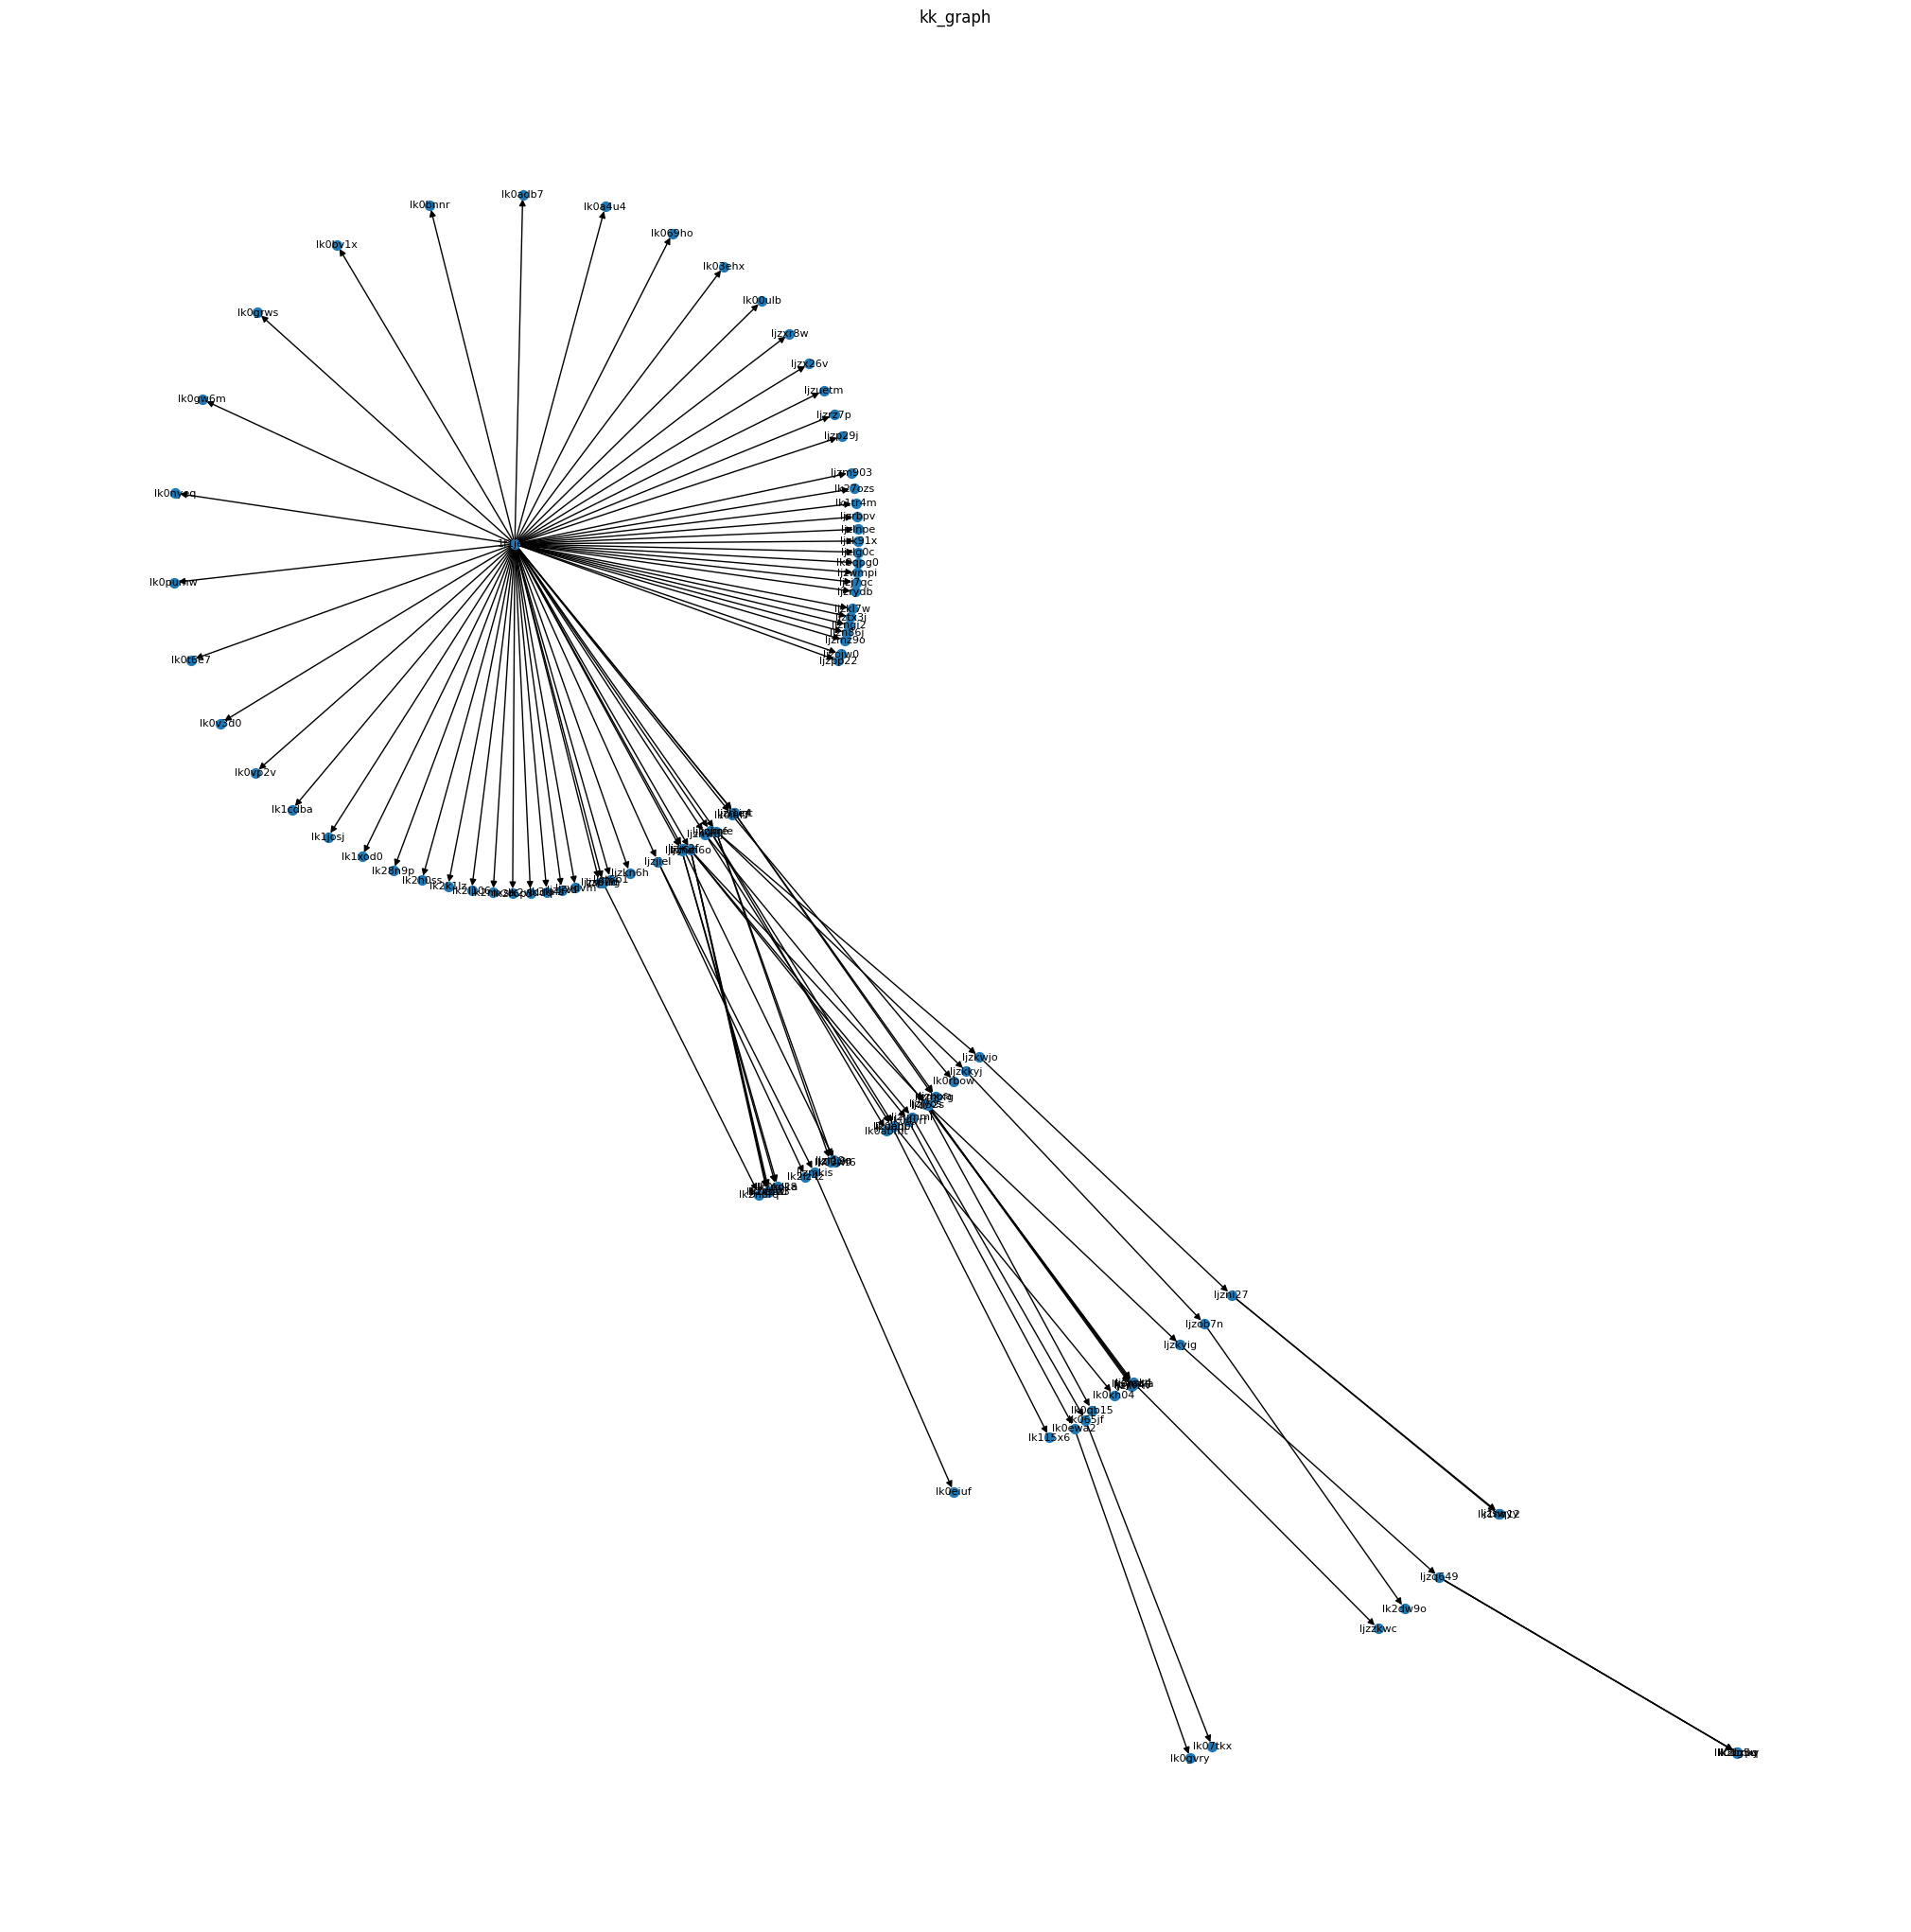

In [7]:
# plot a basic graph of a single comment tree

#make a slice of our orginal data by conversation id (link_id)

data_slice = data[data['link_id'] == 't3_1f1jeir']

#build the graph object and the adjacency list

G_tree_slice, adj_list_slice = reddit_workflow.tree_graph_and_adj_list(data_slice, incl_topic = False)

reddit_workflow.plot_kk_graph(G_tree_slice, 'kk_graph')

We can look at the adjacency list dataframe to see whats in the dataframe as well

In [ ]:
#check the adjancey lists

print(adj_list.head(10))

print(adj_list_slice.head(10))

Finally we can save the objects for later use

In [ ]:
#save the graph object

reddit_workflow.save_graph(G_tree, 'reddit_tree.graphml')

#save the adjacency list

reddit_workflow.save_adj_list(adj_list, 'reddit_adj_list.csv')

<div align="center">
    <h1><strong>BERTopic topic modelling</strong></h1>
</div> 

https://maartengr.github.io/BERTopic/index.html

BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

We are going to use the topic model to assign a topic to each of the nodes in our graph. This will provide more information about the topics of discussion going on in the tree representation of the reddit conversations. 

We can topic model the submissions (i.e. the original post), the comments (i.e. the replies to the orginal post), or both.

In [ ]:
#load data
 
submissions  = pd.read_csv('data/snake_submissions.csv')

comments = pd.read_csv('data/snake_comments.csv')

Model the comments only

In [ ]:
# model the comments

#this will return a dataframe with the comments plus added columns with the topic and a list of topics

comments_df, topic_list = reddit_workflow.topic_model_comments(comments, 'body')

Model the submissions only

In [ ]:
#model the submissions

#this will return a dataframe with the submissions plus added columns with the topic and a list of topics

submissions_df, topic_list = reddit_workflow.topic_model_submissions(submissions, 'title', 'selftext')

Model both

In [ ]:
#model the submissions and comments

#this will return a dataframe with the submissions and comments plus added columns with the topic and a list of topics

combined_df, topic_list = reddit_workflow.topic_model_combined(submissions, comments, 'body', 'selftext', 'title')

We should pass the combined dataframe for the sake of completeness of the graphs. This way the orginal submission and the commetns are in the same topic space. However the "incl_topic" flag needs to be set to True in the function arguments.

In [ ]:
G_combined, adj_list_combined = reddit_workflow.tree_graph_and_adj_list(combined_df, incl_topic = True)

We can check out the adjacency list and finally save the Graph object to a .graphml to explore in a visualisation tool like Gephi.

https://gephi.org/

In [ ]:
print(adj_list_combined.head(10))

reddit_workflow.save_graph(G_combined, 'reddit_combined_tree.graphml')

<div align="center">
    <h1><strong>LDA topic modelling</strong></h1>
</div> 

https://en.m.wikipedia.org/wiki/Latent_Dirichlet_allocation


We are going to use the topic model to assign a topic to each of the nodes in our graph. This will provide more information about the topics of discussion going on in the tree representation of the reddit conversations. 

The major difference is that the LDA method requires you to specifiy the number of topics you want to extract from the text. This can be tricky and there are no magic numbers. You should choose a reasonable number depending on the number of documents in the total corpus. You ma want to experiment.

We can topic model the submissions (i.e. the original post), the comments (i.e. the replies to the orginal post), or both.

Load the data

In [ ]:
#load data
 
submissions  = pd.read_csv('data/snake_submissions.csv')

comments = pd.read_csv('data/snake_comments.csv')

Model the comments only

In [ ]:
comments_lda, lda_model_comments = reddit_workflow.lda_comments(comments, 'body', 5)

Model the submissions only

In [ ]:
submissions_lda, lda_model_submissions = reddit_workflow.lda_submissions(submissions, 'title', 'selftext', 5)

Model both

In [ ]:
combined_lda = reddit_workflow.lda_combined(submissions, comments, 'body', 'selftext', 'title', 5)

Make the graph

In [ ]:
G_combined_lda, adj_list_combined_lda = reddit_workflow.tree_graph_and_adj_list(combined_lda, incl_topic = True)

We can check out the adjacency list and finally save the Graph object to a .graphml to explore in a visualisation tool like Gephi.

https://gephi.org/

In [ ]:
print(adj_list_combined_lda.head(10))

reddit_workflow.save_graph(G_combined_lda, 'reddit_combined_lda_tree.graphml')

<div align="center">
    <h1><strong>Emotion Tagging</strong></h1>
</div> 

https://saifmohammad.com/WebPages/AffectIntensity.htm

Using the NRC lexicon we can assign nodes a score for each of the 8 emotions in the lexicon: Anger, Anticipation, Disgust, Fear, Joy, Sadness, Surpise and Trust. This can later be visualised in programes like Gephi to help understand the way that discourse is structured in the trees.

In [ ]:
comments_emo = reddit_workflow.sentiment_intensity(comments, 'body')

In [ ]:
G_emo, adj_list_emo = reddit_workflow.tree_graph_and_adj_list_emo(comments_emo)

In [ ]:
print(adj_list_emo.head(10))

reddit_workflow.save_graph(G_emo, 'reddit_emo_tree.graphml')